In [1]:
# Imports and housekeeping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.genmod import families
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.metrics import (confusion_matrix, accuracy_score)
sns.set_theme(style="darkgrid")

In [2]:
# Import the main dataset
df = pd.read_csv('churn_clean.csv',dtype={'locationid':np.int64})

In [3]:
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

In [4]:
# Display dataset top 5 rows
df.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,...,172.455519,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,...,242.632554,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,...,159.947583,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,...,119.956840,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,...,149.948316,271.493436,4,4,4,3,4,4,4,5


In [5]:
# Trim dataset to variables relevant to research question
columns = ['Area', 'Children', 'Age', 'Income', 'Marital', 'Gender', 'Churn', 'Outage_sec_perweek', 
           'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']
df_data = pd.DataFrame(df[columns])

In [6]:
# Check data for null or missing values
df_data.isna().any()

Area                    False
Children                False
Age                     False
Income                  False
Marital                 False
Gender                  False
Churn                   False
Outage_sec_perweek      False
Yearly_equip_failure    False
Tenure                  False
MonthlyCharge           False
Bandwidth_GB_Year       False
dtype: bool

In [7]:
# Check data for duplicated rows
df_data.duplicated().sum()

0

In [8]:
# Display summary statistics for entire dataset - continuous variables
df_data.describe()

,Children,Age,Income,Outage_sec_perweek,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
count,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.0877,53.078400,39806.926771,10.001848,0.398000,34.526188,172.624816,3392.341550
std,2.1472,20.698882,28199.916702,2.976019,0.635953,26.443063,42.943094,2185.294852
min,0.0000,18.000000,348.670000,0.099747,0.000000,1.000259,79.978860,155.506715
25%,0.0000,35.000000,19224.717500,8.018214,0.000000,7.917694,139.979239,1236.470827
50%,1.0000,53.000000,33170.605000,10.018560,0.000000,35.430507,167.484700,3279.536903
75%,3.0000,71.000000,53246.170000,11.969485,1.000000,61.479795,200.734725,5586.141370
max,10.0000,89.000000,258900.700000,21.207230,6.000000,71.999280,290.160419,7158.981530


In [9]:
# Display summary statistics for entire dataset - categorical variables
df_data.describe(include = object)

,Area,Marital,Gender,Churn
count,10000,10000,10000,10000
unique,3,5,3,2
top,Suburban,Divorced,Female,No
freq,3346,2092,5025,7350


In [10]:
# Initialize figure size settings
plt.rcParams['figure.figsize'] = [10, 10]

array([[<AxesSubplot:title={'center':'Children'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Income'}>],
       [<AxesSubplot:title={'center':'Outage_sec_perweek'}>,
        <AxesSubplot:title={'center':'Yearly_equip_failure'}>,
        <AxesSubplot:title={'center':'Tenure'}>],
       [<AxesSubplot:title={'center':'MonthlyCharge'}>,
        <AxesSubplot:title={'center':'Bandwidth_GB_Year'}>,
        <AxesSubplot:>]], dtype=object)

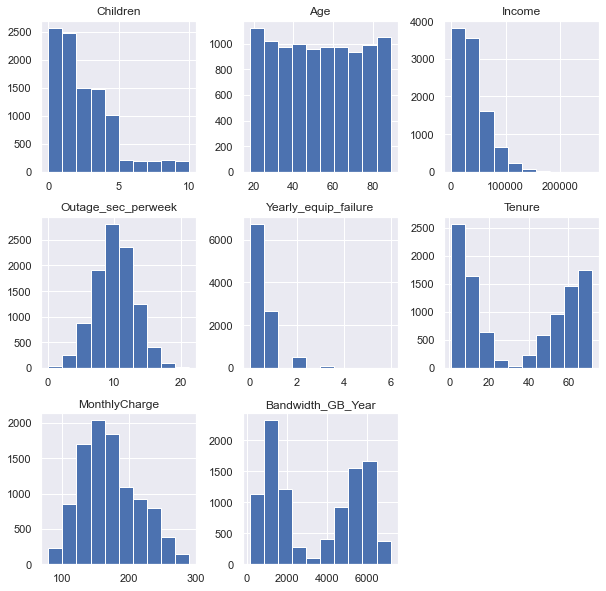

In [11]:
# Display histogram plots for distribution of continuous variables
df_data.hist()

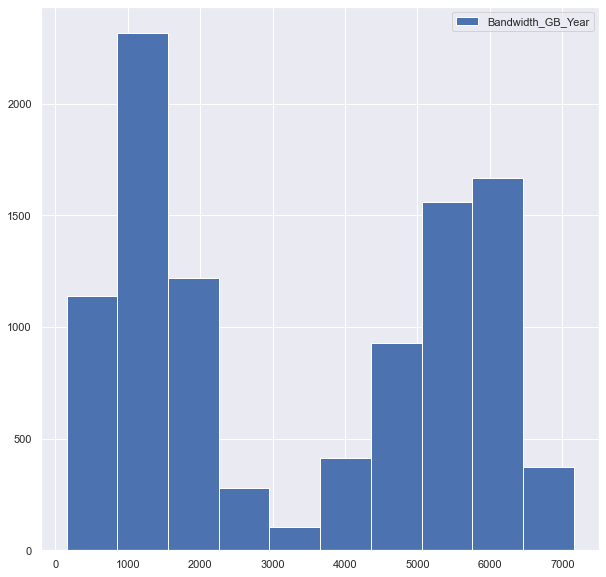

count    10000.000000
mean      3392.341550
std       2185.294852
min        155.506715
25%       1236.470827
50%       3279.536903
75%       5586.141370
max       7158.981530
Name: Bandwidth_GB_Year, dtype: float64

In [12]:
# Display histogram plot and summary statistics for Bandwidth_GB_Year
df_data['Bandwidth_GB_Year'].hist(legend = True)
plt.show()
df_data['Bandwidth_GB_Year'].describe()

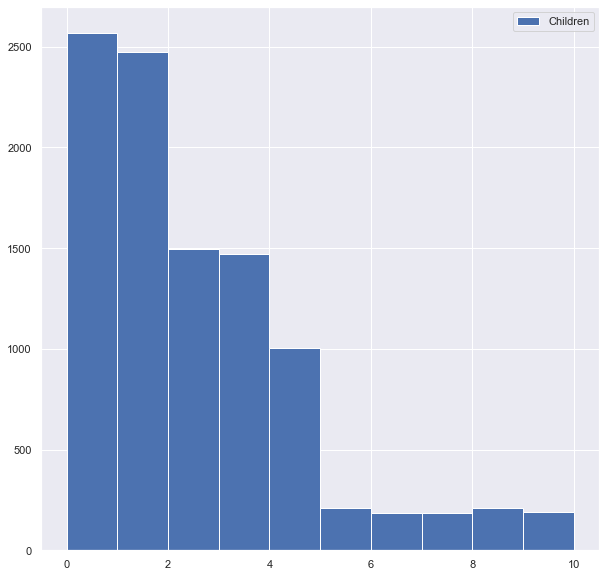

count    10000.0000
mean         2.0877
std          2.1472
min          0.0000
25%          0.0000
50%          1.0000
75%          3.0000
max         10.0000
Name: Children, dtype: float64

In [13]:
# Display histogram plot and summary statistics for Children
df_data['Children'].hist(legend = True)
plt.show()
df_data['Children'].describe()

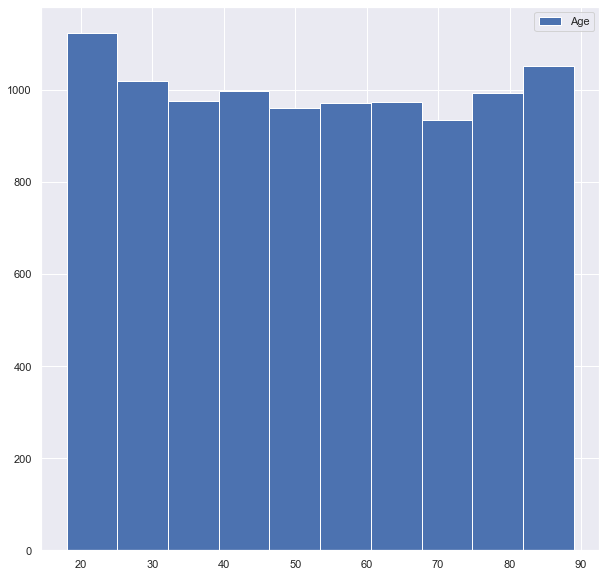

count    10000.000000
mean        53.078400
std         20.698882
min         18.000000
25%         35.000000
50%         53.000000
75%         71.000000
max         89.000000
Name: Age, dtype: float64

In [14]:
# Display histogram plot and summary statistics for Age
df_data['Age'].hist(legend = True)
plt.show()
df_data['Age'].describe()

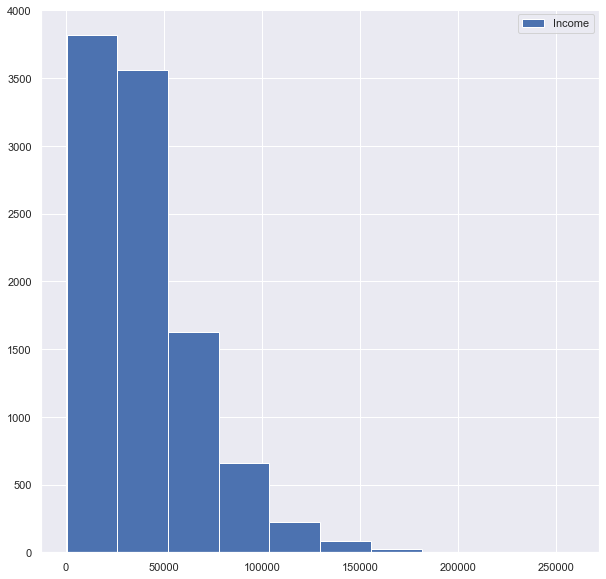

count     10000.000000
mean      39806.926771
std       28199.916702
min         348.670000
25%       19224.717500
50%       33170.605000
75%       53246.170000
max      258900.700000
Name: Income, dtype: float64

In [15]:
# Display histogram plot and summary statistics for Income
df_data['Income'].hist(legend = True)
plt.show()
df_data['Income'].describe()

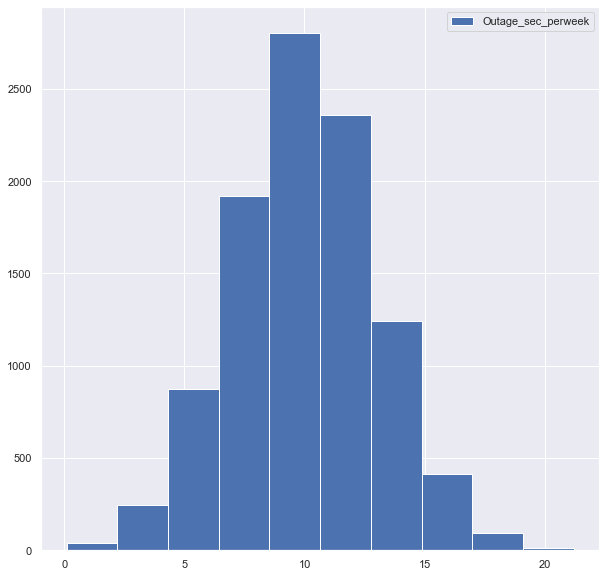

count    10000.000000
mean        10.001848
std          2.976019
min          0.099747
25%          8.018214
50%         10.018560
75%         11.969485
max         21.207230
Name: Outage_sec_perweek, dtype: float64

In [16]:
# Display histogram plot and summary statistics for Outage_sec_perweek
df_data['Outage_sec_perweek'].hist(legend = True)
plt.show()
df_data['Outage_sec_perweek'].describe()

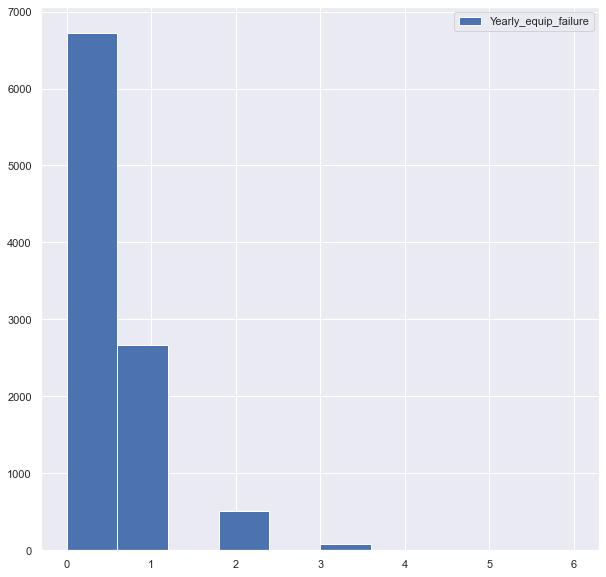

count    10000.000000
mean         0.398000
std          0.635953
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          6.000000
Name: Yearly_equip_failure, dtype: float64

In [17]:
# Display histogram plot and summary statistics for Yearly_equip_failure
df_data['Yearly_equip_failure'].hist(legend = True)
plt.show()
df_data['Yearly_equip_failure'].describe()

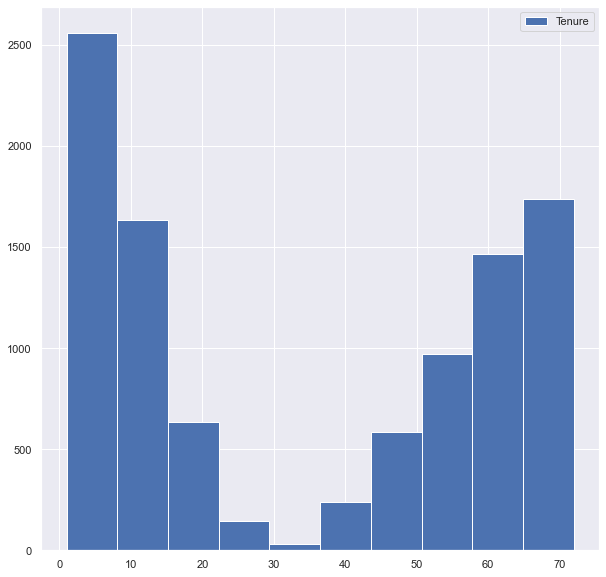

count    10000.000000
mean        34.526188
std         26.443063
min          1.000259
25%          7.917694
50%         35.430507
75%         61.479795
max         71.999280
Name: Tenure, dtype: float64

In [18]:
# Display histogram plot and summary statistics for Tenure
df_data['Tenure'].hist(legend = True)
plt.show()
df_data['Tenure'].describe()

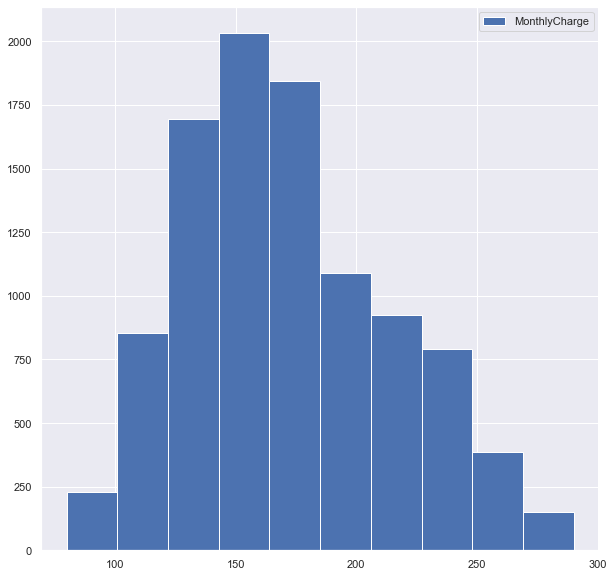

count    10000.000000
mean       172.624816
std         42.943094
min         79.978860
25%        139.979239
50%        167.484700
75%        200.734725
max        290.160419
Name: MonthlyCharge, dtype: float64

In [19]:
# Display histogram plot and summary statistics for MonthlyCharge
df_data['MonthlyCharge'].hist(legend = True)
plt.show()
df_data['MonthlyCharge'].describe()

<AxesSubplot:xlabel='Churn', ylabel='count'>

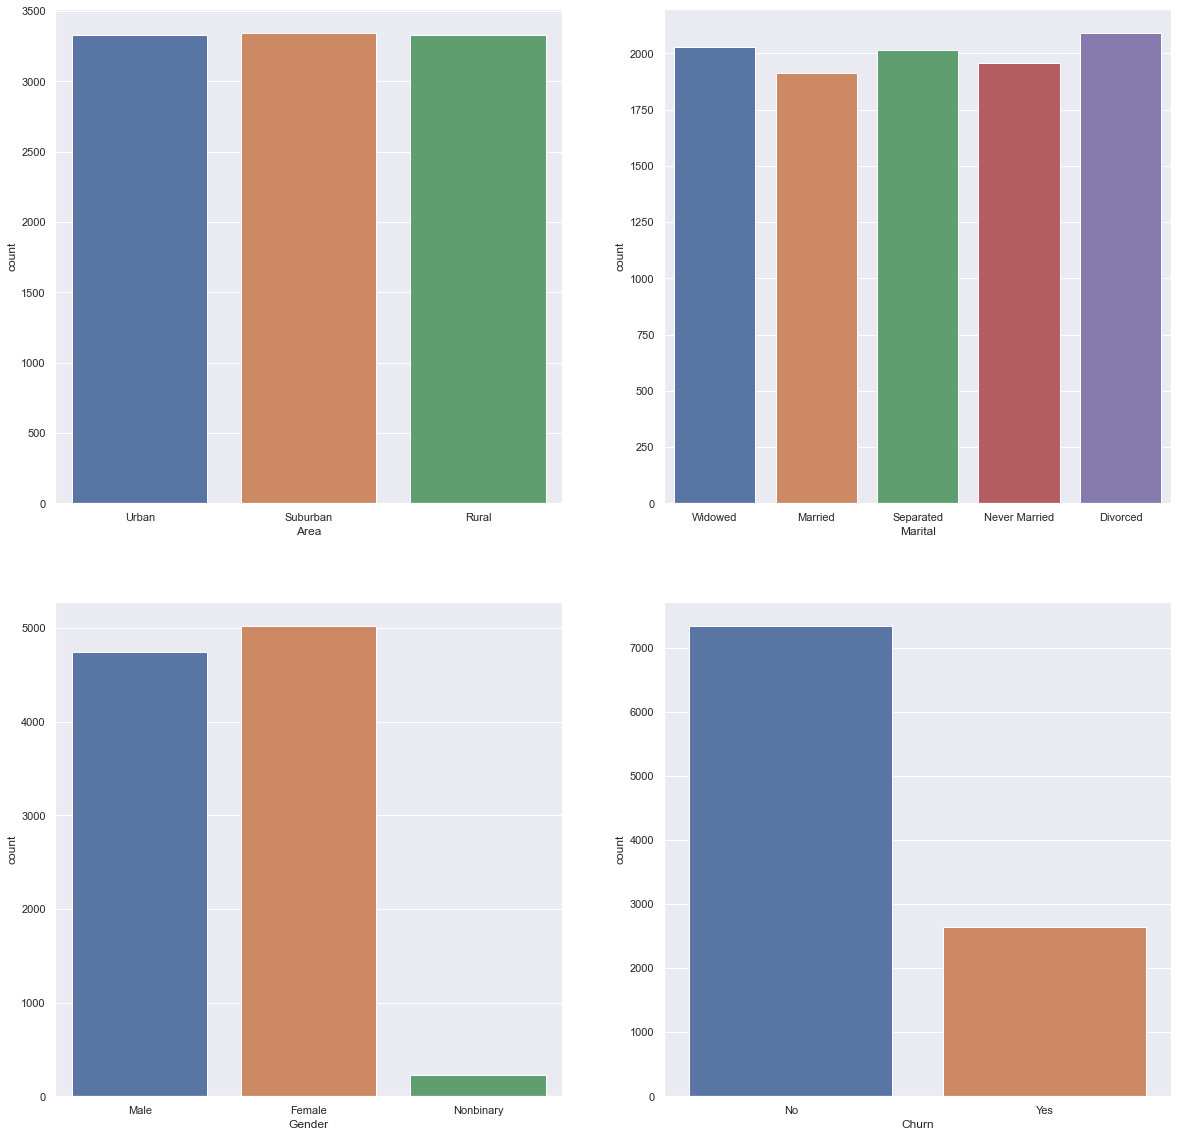

In [20]:
# Display countplots for distribution of categorical variables
fig, ax = plt.subplots(figsize = (20,20), ncols = 2, nrows = 2)
sns.countplot(x='Area', data=df_data, ax = ax[0][0])
sns.countplot(x='Marital', data=df_data, ax = ax[0][1])
sns.countplot(x='Gender', data=df_data, ax = ax[1][0])
sns.countplot(x='Churn', data=df_data, ax = ax[1][1])

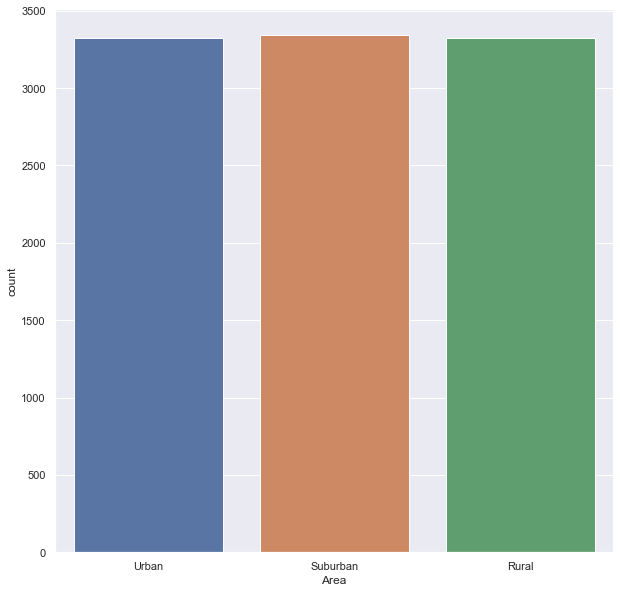

count        10000
unique           3
top       Suburban
freq          3346
Name: Area, dtype: object

In [21]:
# Display countplot and summary statistics for Area
sns.countplot(x='Area', data=df_data)
plt.show()
df_data['Area'].describe()

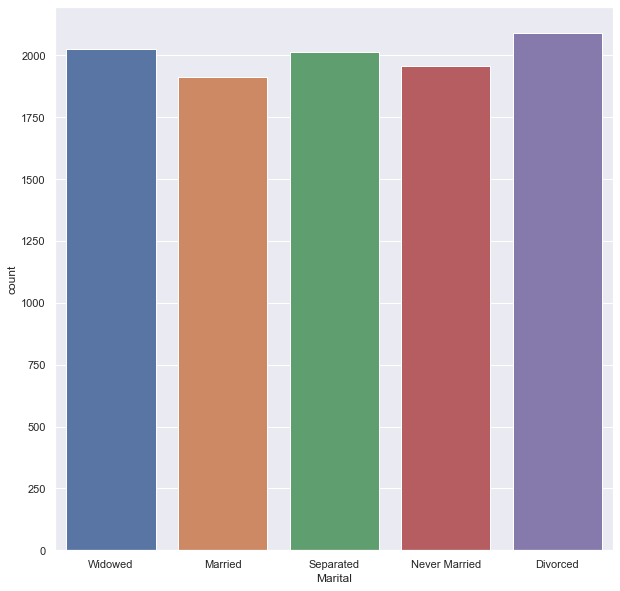

count        10000
unique           5
top       Divorced
freq          2092
Name: Marital, dtype: object

In [22]:
# Display countplot and summary statistics for Marital
sns.countplot(x='Marital', data=df_data)
plt.show()
df_data['Marital'].describe()

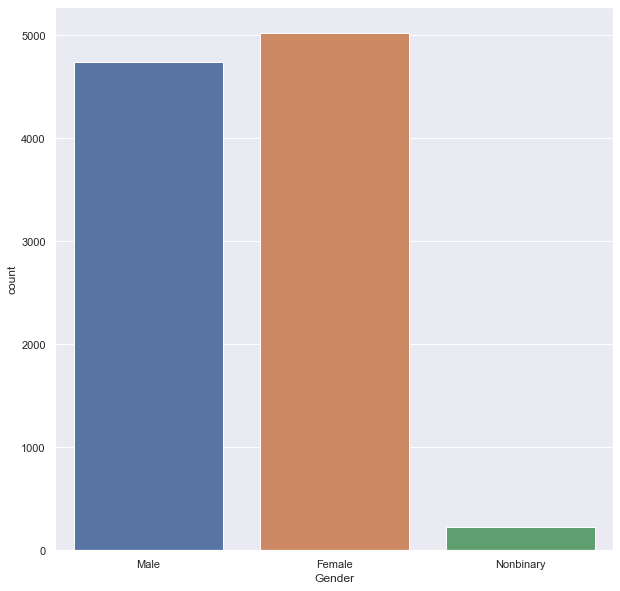

count      10000
unique         3
top       Female
freq        5025
Name: Gender, dtype: object

In [23]:
# Display countplot and summary statistics for Gender
sns.countplot(x='Gender', data=df_data)
plt.show()
df_data['Gender'].describe()

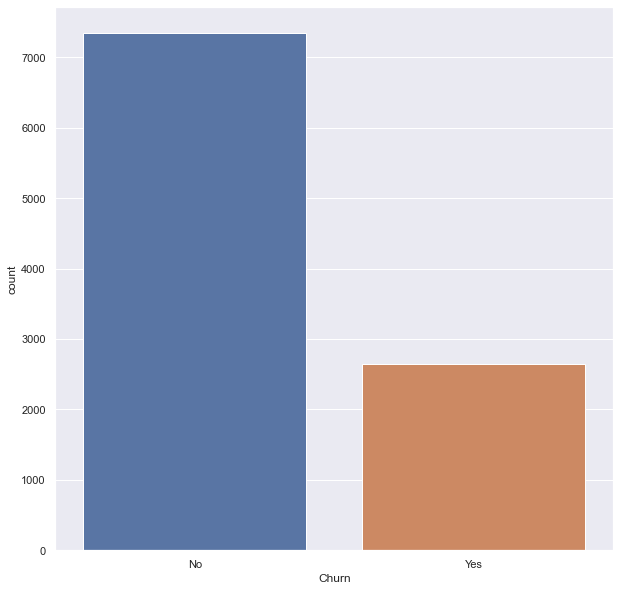

count     10000
unique        2
top          No
freq       7350
Name: Churn, dtype: object

In [24]:
# Display countplot and summary statistics for Churn
sns.countplot(x='Churn', data=df_data)
plt.show()
df_data['Churn'].describe()

In [25]:
# Reassign data types
for col in df_data:
    if df_data[col].dtypes == 'object':
        df_data[col] = df_data[col].astype('category')
    if df_data[col].dtypes == 'int64':
        df_data[col] = df_data[col].astype(int)
    if df_data[col].dtypes == 'float64':
        df_data[col] = df_data[col].astype(float)

In [26]:
# Display dataset info and observe data type changes
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Area                  10000 non-null  category
 1   Children              10000 non-null  int32   
 2   Age                   10000 non-null  int32   
 3   Income                10000 non-null  float64 
 4   Marital               10000 non-null  category
 5   Gender                10000 non-null  category
 6   Churn                 10000 non-null  category
 7   Outage_sec_perweek    10000 non-null  float64 
 8   Yearly_equip_failure  10000 non-null  int32   
 9   Tenure                10000 non-null  float64 
 10  MonthlyCharge         10000 non-null  float64 
 11  Bandwidth_GB_Year     10000 non-null  float64 
dtypes: category(4), float64(5), int32(3)
memory usage: 547.6 KB


In [27]:
# Use cat.codes for label encoding of 4 categorical variables
df_data['Area_cat'] = df_data['Area'].cat.codes
df_data['Marital_cat'] = df_data['Marital'].cat.codes
df_data['Gender_cat'] = df_data['Gender'].cat.codes
df_data['Churn_cat'] = df_data['Churn'].cat.codes

In [28]:
# Display dataset top 5 rows from label encoded variables
df_data[['Area', 'Marital', 'Gender', 'Churn', 'Area_cat', 'Marital_cat', 'Gender_cat', 'Churn_cat']].head()

,Area,Marital,Gender,Churn,Area_cat,Marital_cat,Gender_cat,Churn_cat
0,Urban,Widowed,Male,No,2,4,1,0
1,Urban,Married,Female,Yes,2,1,0,1
2,Urban,Widowed,Female,No,2,4,0,0
3,Suburban,Married,Male,No,1,1,1,0
4,Suburban,Separated,Male,Yes,1,3,1,1


<AxesSubplot:xlabel='Churn', ylabel='Gender_cat'>

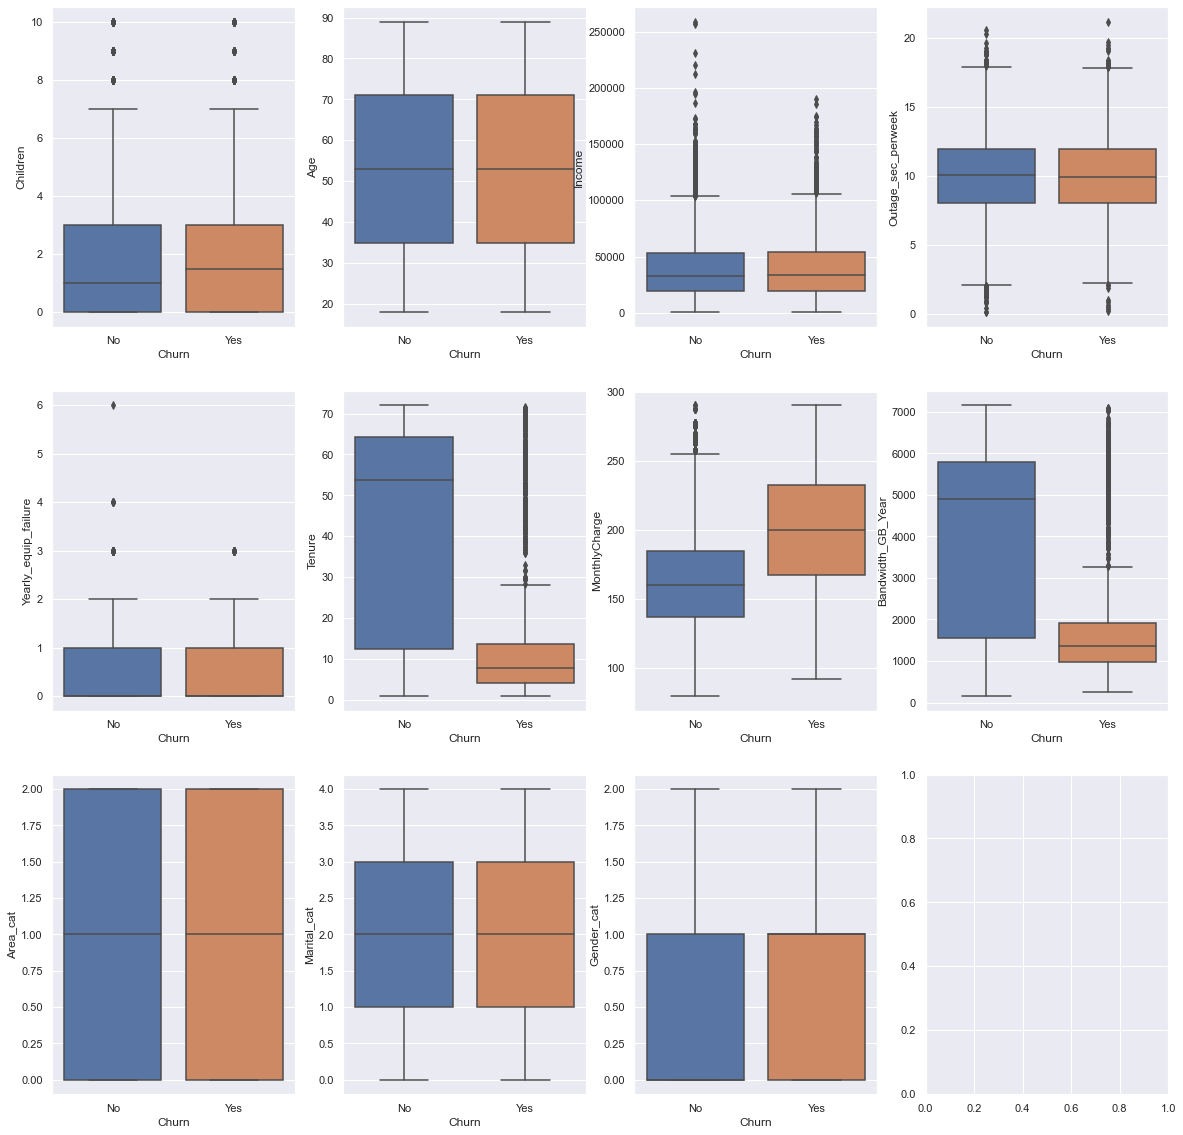

In [29]:
# Display boxplots for bivariate analysis of variables - dependent variable = Churn
fig, ax = plt.subplots(figsize = (20, 20), ncols = 4, nrows = 3)
sns.boxplot(x = 'Churn', y = 'Children', data = df_data, ax = ax[0][0])
sns.boxplot(x = 'Churn', y = 'Age', data = df_data, ax = ax[0][1])
sns.boxplot(x = 'Churn', y = 'Income', data = df_data, ax = ax[0][2])
sns.boxplot(x = 'Churn', y = 'Outage_sec_perweek', data = df_data, ax = ax[0][3])
sns.boxplot(x = 'Churn', y = 'Yearly_equip_failure', data = df_data, ax = ax[1][0])
sns.boxplot(x = 'Churn', y = 'Tenure', data = df_data, ax = ax[1][1])
sns.boxplot(x = 'Churn', y = 'MonthlyCharge', data = df_data, ax = ax[1][2])
sns.boxplot(x = 'Churn', y = 'Bandwidth_GB_Year', data = df_data, ax = ax[1][3])
sns.boxplot(x = 'Churn', y = 'Area_cat', data = df_data, ax = ax[2][0])
sns.boxplot(x = 'Churn', y = 'Marital_cat', data = df_data, ax = ax[2][1])
sns.boxplot(x = 'Churn', y = 'Gender_cat', data = df_data, ax = ax[2][2])

In [30]:
# Export prepared dataframe to csv
df_data.to_csv(r'C:\Users\wstul\d208\churn_clean_perpared.csv')

In [31]:
# Create initial model and display summary
mdl_churn_vs_all = logit("Churn_cat ~ Area_cat + Children + Age + Income + Marital_cat + Gender_cat + Bandwidth_GB_Year + \
                        Outage_sec_perweek + Yearly_equip_failure + MonthlyCharge + Tenure", data=df_data).fit()
print(mdl_churn_vs_all.summary())

Optimization terminated successfully.
         Current function value: 0.319631
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_cat   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9988
Method:                           MLE   Df Model:                           11
Date:                Tue, 17 May 2022   Pseudo R-squ.:                  0.4472
Time:                        13:50:45   Log-Likelihood:                -3196.3
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.9769      0.228    -26.185      0.000      -6.424      -5.530

Confusion Matrix : 
 [[6794  556]
 [ 955 1695]]
Test accuracy =  0.8489


(<Figure size 720x720 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.7313432835820897, 0.9212827988338191),
  ('0', '1'): (0.0,
   0.9246050579700318,
   0.7313432835820897,
   0.0753949420299681),
  ('1', '0'): (0.7363184079601991, 0.0, 0.263681592039801, 0.3591800915188365),
  ('1', '1'): (0.7363184079601991,
   0.36250235065504915,
   0.263681592039801,
   0.6374976493449507)})

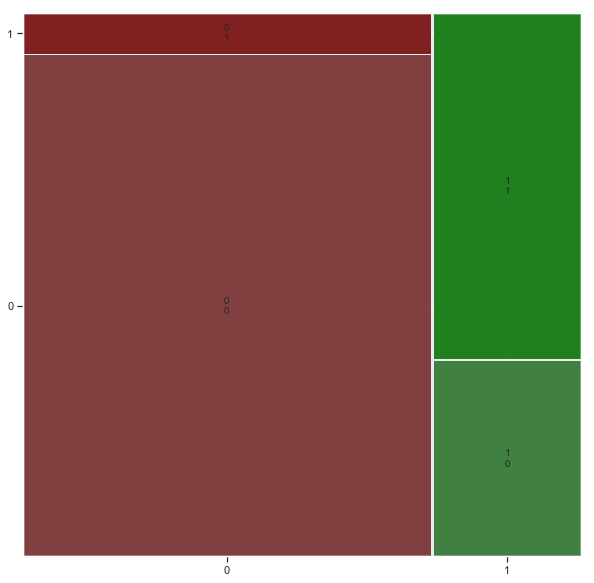

In [32]:
# generating predictions, confusion matrix, accuracy score and mosaic
Xtest = df_data[['Area_cat', 'Children', 'Age', 'Income', 'Marital_cat', 'Gender_cat', 'Outage_sec_perweek', 
           'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']]
ytest = df_data['Churn_cat']
yhat = mdl_churn_vs_all.predict(Xtest)
prediction = list(map(round, yhat))
conf_matrix = confusion_matrix(ytest, prediction)
print ("Confusion Matrix : \n", conf_matrix)
print('Test accuracy = ', accuracy_score(ytest, prediction))
mosaic(conf_matrix)

In [33]:
df_data.corr()

,Children,Age,Income,Outage_sec_perweek,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year,Area_cat,Marital_cat,Gender_cat,Churn_cat
Children,1.000000,-0.029732,0.009942,0.001889,0.007321,-0.005091,-0.009781,0.025585,-0.007879,0.000045,0.006032,-0.004264
Age,-0.029732,1.000000,-0.004091,-0.008047,0.008577,0.016979,0.010729,-0.014724,0.011745,-0.009721,-0.005660,0.005630
Income,0.009942,-0.004091,1.000000,-0.010011,0.005423,0.002114,-0.003014,0.003674,0.002557,-0.005045,-0.018436,0.005937
Outage_sec_perweek,0.001889,-0.008047,-0.010011,1.000000,0.002909,0.002932,0.020496,0.004176,0.000239,-0.016180,0.008887,-0.000156
Yearly_equip_failure,0.007321,0.008577,0.005423,0.002909,1.000000,0.012435,-0.007172,0.012034,-0.006554,0.001183,0.014750,-0.015927
Tenure,-0.005091,0.016979,0.002114,0.002932,0.012435,1.000000,-0.003337,0.991495,-0.016615,0.003241,-0.016051,-0.485475
MonthlyCharge,-0.009781,0.010729,-0.003014,0.020496,-0.007172,-0.003337,1.000000,0.060406,0.003951,-0.002266,0.009147,0.372938
Bandwidth_GB_Year,0.025585,-0.014724,0.003674,0.004176,0.012034,0.991495,0.060406,1.000000,-0.016575,0.001499,-0.001469,-0.441669
Area_cat,-0.007879,0.011745,0.002557,0.000239,-0.006554,-0.016615,0.003951,-0.016575,1.000000,0.013733,0.004057,0.014166
Marital_cat,0.000045,-0.009721,-0.005045,-0.016180,0.001183,0.003241,-0.002266,0.001499,0.013733,1.000000,-0.008360,0.012716


In [34]:
# Perform variance inflation factor analysis for initial feature set
X = df_data[['Area_cat', 'Children', 'Age', 'Income', 'Marital_cat', 'Gender_cat', 'Outage_sec_perweek', 
           'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']]
vif_data = pd.DataFrame()
vif_data['IndVar'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                  IndVar         VIF
0               Area_cat    2.425522
1               Children    2.072716
2                    Age    7.057506
3                 Income    2.850023
4            Marital_cat    2.810898
5             Gender_cat    1.916246
6     Outage_sec_perweek    9.240040
7   Yearly_equip_failure    1.381941
8                 Tenure  250.810141
9          MonthlyCharge   18.436436
10     Bandwidth_GB_Year  316.867066


In [35]:
# Drop 1 high VIF variable
X = X.drop('Bandwidth_GB_Year', axis = 1)

In [36]:
# Perform variance inflation factor analysis for trimmed feature set
vif_data = pd.DataFrame()
vif_data['IndVar'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                 IndVar        VIF
0              Area_cat   2.425161
1              Children   1.897252
2                   Age   6.460408
3                Income   2.847797
4           Marital_cat   2.810827
5            Gender_cat   1.879624
6    Outage_sec_perweek   9.233796
7  Yearly_equip_failure   1.381910
8                Tenure   2.605773
9         MonthlyCharge  11.151377


In [37]:
# Drop 1 high VIF variable
X = X.drop('Outage_sec_perweek', axis = 1)

In [38]:
# Perform variance inflation factor analysis for trimmed feature set
vif_data = pd.DataFrame()
vif_data['IndVar'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                 IndVar       VIF
0              Area_cat  2.398333
1              Children  1.879604
2                   Age  6.116797
3                Income  2.807292
4           Marital_cat  2.775227
5            Gender_cat  1.863478
6  Yearly_equip_failure  1.377841
7                Tenure  2.569440
8         MonthlyCharge  8.858859


In [39]:
# Drop 1 high VIF variable
X = X.drop('Age', axis = 1)

In [40]:
# Perform variance inflation factor analysis for trimmed feature set
vif_data = pd.DataFrame()
vif_data['IndVar'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                 IndVar       VIF
0              Area_cat  2.365519
1              Children  1.872816
2                Income  2.765505
3           Marital_cat  2.739215
4            Gender_cat  1.852198
5  Yearly_equip_failure  1.372769
6                Tenure  2.523888
7         MonthlyCharge  6.719572


In [41]:
# Create first reduced model and display summary
mdl_churn_vs_reduced = logit("Churn_cat ~ Area_cat + Children + Income + Marital_cat + Gender_cat + Yearly_equip_failure + MonthlyCharge + Tenure",
                           data=df_data).fit()
print(mdl_churn_vs_reduced.summary())

Optimization terminated successfully.
         Current function value: 0.341735
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_cat   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            8
Date:                Tue, 17 May 2022   Pseudo R-squ.:                  0.4090
Time:                        13:51:54   Log-Likelihood:                -3417.4
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.2842      0.173    -30.593      0.000      -5.623      -4.946

Confusion Matrix : 
 [[6738  612]
 [1047 1603]]
Test accuracy =  0.8341


(<Figure size 720x720 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.7313432835820897, 0.9136890636653332),
  ('0', '1'): (0.0,
   0.9170113228015457,
   0.7313432835820897,
   0.08298867719845412),
  ('1', '0'): (0.7363184079601991, 0.0, 0.263681592039801, 0.3937817338431643),
  ('1', '1'): (0.7363184079601991,
   0.39710399297937693,
   0.263681592039801,
   0.6028960070206231)})

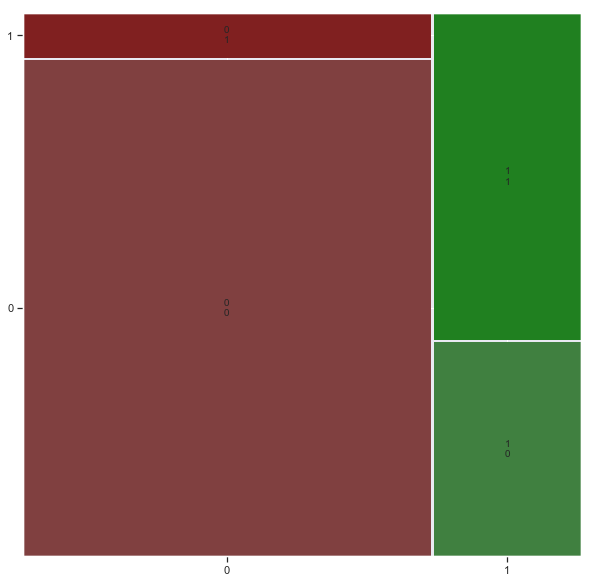

In [42]:
# generating predictions, confusion matrix, accuracy score and mosaic
Xtest = df_data[['Area_cat', 'Children', 'Income', 'Marital_cat', 'Gender_cat', 
           'Yearly_equip_failure', 'MonthlyCharge', 'Tenure']]
ytest = df_data['Churn_cat']
yhat = mdl_churn_vs_reduced.predict(Xtest)
prediction = list(map(round, yhat))
conf_matrix = confusion_matrix(ytest, prediction)
print ("Confusion Matrix : \n", conf_matrix)
print('Test accuracy = ', accuracy_score(ytest, prediction))
mosaic(conf_matrix)

In [43]:
# Create further reduced model without high p-values and display summary
mdl_churn_vs_features = logit("Churn_cat ~ MonthlyCharge + Tenure",
                           data=df_data).fit()
print(mdl_churn_vs_features.summary())

Optimization terminated successfully.
         Current function value: 0.342087
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_cat   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 May 2022   Pseudo R-squ.:                  0.4084
Time:                        13:52:24   Log-Likelihood:                -3420.9
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.1525      0.150    -34.283      0.000      -5.447      -4.858
MonthlyCharge     0.

Confusion Matrix : 
 [[6738  612]
 [1050 1600]]
Test accuracy =  0.8338


(<Figure size 720x720 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.7313432835820897, 0.9136890636653332),
  ('0', '1'): (0.0,
   0.9170113228015457,
   0.7313432835820897,
   0.08298867719845412),
  ('1', '0'): (0.7363184079601991,
   0.0,
   0.263681592039801,
   0.39491004826678366),
  ('1', '1'): (0.7363184079601991,
   0.3982323074029963,
   0.263681592039801,
   0.6017676925970036)})

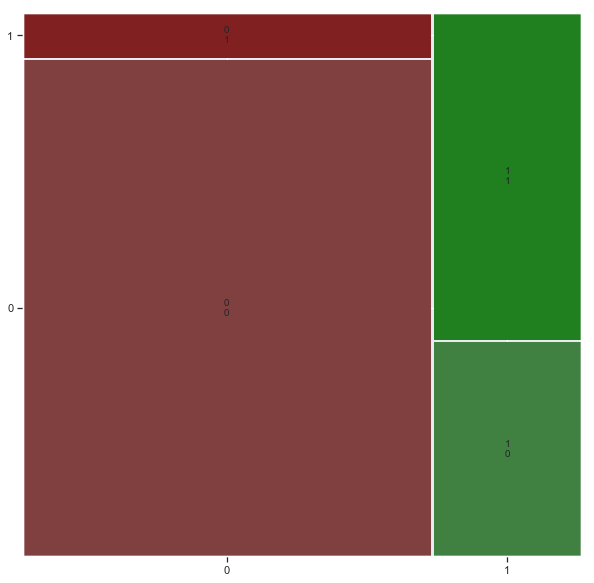

In [44]:
# generating predictions, confusion matrix, accuracy score and mosaic
Xtest = df_data[['MonthlyCharge', 'Tenure']]
ytest = df_data['Churn_cat']
yhat = mdl_churn_vs_features.predict(Xtest)
prediction = list(map(round, yhat))
conf_matrix = confusion_matrix(ytest, prediction)
print ("Confusion Matrix : \n", conf_matrix)
print('Test accuracy = ', accuracy_score(ytest, prediction))
mosaic(conf_matrix)

In [45]:
# Create final reduced model and display summary
mdl_churn_vs_features_final = logit("Churn_cat ~ MonthlyCharge + Tenure",
                           data=df_data).fit()
print(mdl_churn_vs_features_final.summary())

Optimization terminated successfully.
         Current function value: 0.342087
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_cat   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 May 2022   Pseudo R-squ.:                  0.4084
Time:                        13:52:42   Log-Likelihood:                -3420.9
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.1525      0.150    -34.283      0.000      -5.447      -4.858
MonthlyCharge     0.

Orignal Confusion Matrix : 
 [[6794  556]
 [ 955 1695]]
Orignal accuracy =  0.8489
Final Confusion Matrix : 
 [[6738  612]
 [1050 1600]]
Final accuracy =  0.8338


(<Figure size 720x720 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.7313432835820897, 0.9136890636653332),
  ('0', '1'): (0.0,
   0.9170113228015457,
   0.7313432835820897,
   0.08298867719845412),
  ('1', '0'): (0.7363184079601991,
   0.0,
   0.263681592039801,
   0.39491004826678366),
  ('1', '1'): (0.7363184079601991,
   0.3982323074029963,
   0.263681592039801,
   0.6017676925970036)})

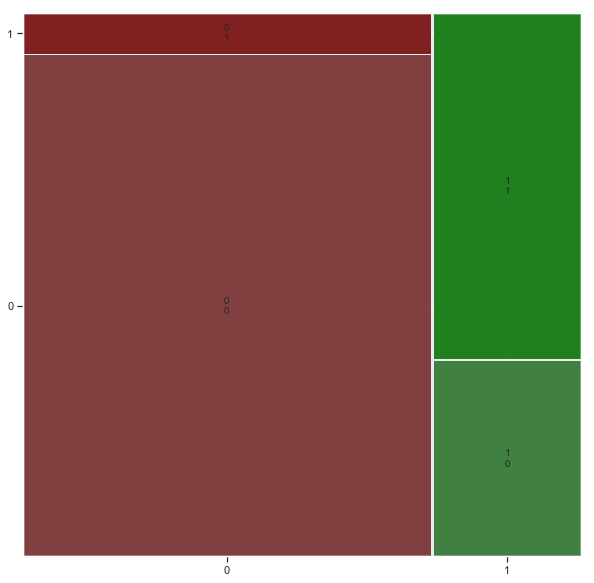

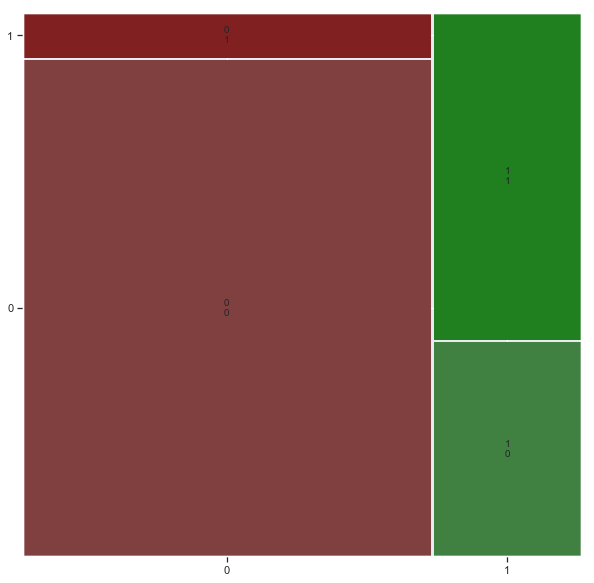

In [46]:
# generating predictions, confusion matrix, accuracy score and mosaic for original and final models
Xorig = df_data[['Area_cat', 'Children', 'Age', 'Income', 'Marital_cat', 'Gender_cat', 'Outage_sec_perweek', 
           'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']]
yorig = df_data['Churn_cat']
yhat_orig = mdl_churn_vs_all.predict(Xorig)
prediction_orig = list(map(round, yhat_orig))
conf_matrix_orig = confusion_matrix(yorig, prediction_orig)
Xfinal = df_data[['MonthlyCharge', 'Tenure']]
yfinal = df_data['Churn_cat']
yhat_final = mdl_churn_vs_features_final.predict(Xfinal)
prediction_final = list(map(round, yhat_final))
conf_matrix_final = confusion_matrix(yfinal, prediction_final)
print ("Orignal Confusion Matrix : \n", conf_matrix_orig)
print('Orignal accuracy = ', accuracy_score(yorig, prediction_orig))
print ("Final Confusion Matrix : \n", conf_matrix_final)
print('Final accuracy = ', accuracy_score(yfinal, prediction_final))
mosaic(conf_matrix_orig)
mosaic(conf_matrix_final)

<AxesSubplot:xlabel='MonthlyCharge'>

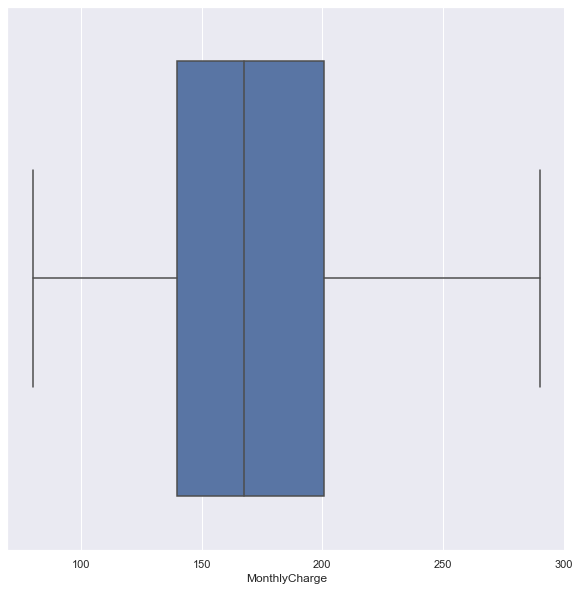

In [47]:
sns.boxplot(x='MonthlyCharge',data=df_data)

<AxesSubplot:xlabel='Tenure'>

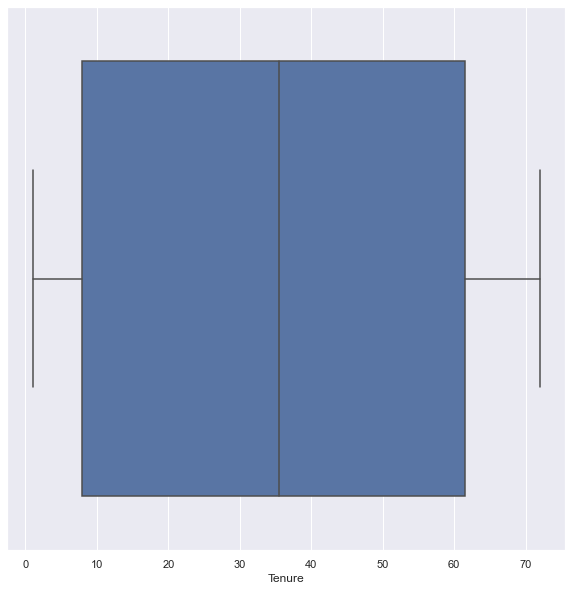

In [48]:
sns.boxplot(x='Tenure',data=df_data)

In [49]:
# Box-Tidwell
# Define continuous variables
continuous_var = ['MonthlyCharge', 'Tenure']

# Add logit transform interaction terms (natural log) for continuous variables e.g.. Age * Log(Age)
for var in continuous_var:
    df_data[f'{var}:Log_{var}'] = df_data[var].apply(lambda x: x * np.log(x))

# Keep columns related to continuous variables
cols_to_keep = continuous_var + df_data.columns.tolist()[-len(continuous_var):]

# Redefining variables to include interaction terms
X_lt = df_data[cols_to_keep]
y_lt = df_data['Churn_cat']

# Add constant term
X_lt_constant = sm.add_constant(X_lt, prepend=False)
  
# Building model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Churn_cat   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3420.6
Date:                Tue, 17 May 2022   Deviance:                       6841.2
Time:                        13:54:51   Pearson chi2:                 8.03e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
MonthlyCha